In [1]:
import numpy as np
import os
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
import tensorflow.keras as keras
from tensorflow.keras import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.layers import LSTM, Dense, Flatten, BatchNormalization, Dropout, GRU
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import module
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [2]:
countriesOfInterest = {"HK", "JP", 'ZA', 'TN', 'TR', 'GB', 'MX', 'US', 'CO', 'EC', 'AU', 'NZ'}
countriesOfInterest = ["ZA", "EG", "TW", "JP", "DK", "FI", "US", "CA", "AU", "NZ", "BR", "CO"]
#countriesOfInterest = list(countriesOfInterest & {"ZA", "EG", "TW", "JP", "DK", "FI", "US", "CA", "AU", "NZ", "BR", "CO"})

enc = OneHotEncoder()
enc.fit(np.array(countriesOfInterest).reshape(-1, 1))

OneHotEncoder(categories='auto', drop=None, dtype=<class 'numpy.float64'>,
              handle_unknown='error', sparse=True)

In [3]:
seconds = 5
samplerate = 100
train_x, train_labels, val_x, val_labels, class_weights = module.getSamples(1, 1, 1, seconds, samplerate, countriesOfInterest,
               enc, verbose = 0)

### Fit model

In [4]:
model = keras.Sequential()
model.add(LSTM(32, 
               input_shape=(train_x.shape[1], train_x.shape[2]), 
               return_sequences = True,
          #     recurrent_dropout = .5,
          #     kernel_regularizer=regularizers.l2(0.01),
              ))
model.add(BatchNormalization())
model.add(LSTM(32, 
             #  input_shape=(train_x.shape[1], train_x.shape[2]), 
               return_sequences = False,
           #    recurrent_dropout = .5,
               go_backwards = True
          #     kernel_regularizer=regularizers.l2(0.01),
              ))
model.add(BatchNormalization())
#model.add(Dropout(.5))
model.add(Dense(32, activation= "relu"))
model.add(BatchNormalization())
#model.add(Dropout(.5))
model.add(Dense(len(enc.categories_[0]), activation= "softmax"))
adam = keras.optimizers.Adam(lr=0.001)
model.compile(loss = "categorical_crossentropy", optimizer= adam, metrics=["acc"])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 500, 32)           7424      
_________________________________________________________________
batch_normalization (BatchNo (None, 500, 32)           128       
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                8320      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32)                128       
_________________________________________________________________
dense (Dense)                (None, 32)                1056      
_________________________________________________________________
batch_normalization_2 (Batch (None, 32)                128       
_________________________________________________________________
dense_1 (Dense)              (None, 12)                3

train [8000. 8000. 8000. 8000. 8000. 8000. 8000. 8000. 8000. 8000. 8000. 8000.]
val [2174. 2376. 2012. 2474. 2016. 2889. 2317. 2935. 2454. 2767. 2826. 3645.]
Train on 96000 samples, validate on 30885 samples
Epoch 1/5
96000/96000 [==============================] - 468s 5ms/sample - loss: 2.5548 - acc: 0.1080 - val_loss: 2.4999 - val_acc: 0.0907
Epoch 2/5
96000/96000 [==============================] - 700s 7ms/sample - loss: 2.4521 - acc: 0.1284 - val_loss: 2.4847 - val_acc: 0.1076
Epoch 3/5
96000/96000 [==============================] - 649s 7ms/sample - loss: 2.4386 - acc: 0.1398 - val_loss: 2.4749 - val_acc: 0.1183
Epoch 4/5
96000/96000 [==============================] - 739s 8ms/sample - loss: 2.4286 - acc: 0.1458 - val_loss: 2.4657 - val_acc: 0.1163
Epoch 5/5
30885/30885 [==============================] - 47s 2ms/sample


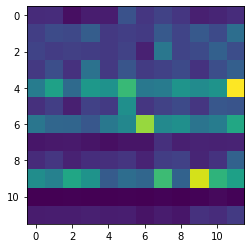

96000/96000 [==============================] - 106s 1ms/sample


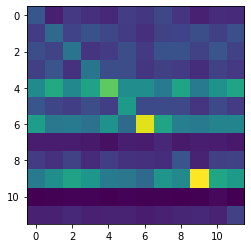

train [8000. 8000. 8000. 8000. 8000. 8000. 8000. 8000. 8000. 8000. 8000. 8000.]
val [2393. 2146. 1842. 2150. 2199. 2276. 2622. 2592. 2704. 3153. 2481. 3006.]
Train on 96000 samples, validate on 29564 samples
Epoch 6/10
96000/96000 [==============================] - 972s 10ms/sample - loss: 2.4513 - acc: 0.1309 - val_loss: 2.4656 - val_acc: 0.1188
Epoch 7/10
96000/96000 [==============================] - 967s 10ms/sample - loss: 2.4330 - acc: 0.1419 - val_loss: 2.4670 - val_acc: 0.1215
Epoch 8/10
96000/96000 [==============================] - 789s 8ms/sample - loss: 2.4215 - acc: 0.1510 - val_loss: 2.4757 - val_acc: 0.1203
Epoch 9/10
96000/96000 [==============================] - 789s 8ms/sample - loss: 2.4145 - acc: 0.1531 - val_loss: 2.4647 - val_acc: 0.1306
Epoch 10/10
29564/29564 [==============================] - 37s 1ms/sample


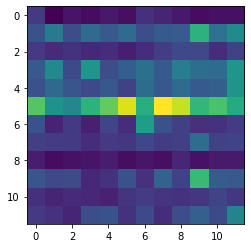

96000/96000 [==============================] - 117s 1ms/sample


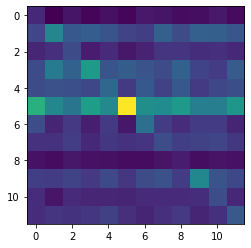

train [8000. 8000. 8000. 8000. 8000. 8000. 8000. 8000. 8000. 8000. 8000. 8000.]
val [2276. 1943. 2159. 2799. 2254. 2969. 2264. 2734. 2321. 2646. 2014. 2950.]
Train on 96000 samples, validate on 29329 samples
Epoch 11/15
96000/96000 [==============================] - 845s 9ms/sample - loss: 2.4268 - acc: 0.1467 - val_loss: 2.4636 - val_acc: 0.1298
Epoch 12/15
91728/96000 [===========================>..] - ETA: 34s - loss: 2.4049 - acc: 0.1583 

In [ ]:
#add recurrent dropout to add noise to duration
desc = "LSTM32_32_D32_Out_5Step_01LR_5H_forced"
log_dir = os.path.join(
    "logs",
    "Overfit",
    desc
)
model_dir = os.path.join(
    "pickle",
    "save"
)

train_n = 100
sample_n = 8000
val_n  = int(2*train_n/5)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
epochs = 5
iterations = 10
learn_rate = 0.01
batch_size = 5096
module.train(iterations, learn_rate, train_n, sample_n, val_n, seconds, samplerate,
                countriesOfInterest, enc, epochs, tensorboard_callback, model_dir,
                model, batch_size)